In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
import tinyarray
from scipy import linalg as la
from scipy.sparse import linalg as sla
from types import SimpleNamespace
import argparse
from copy import deepcopy
from utils2 import Regular_Polygon


In [2]:
lat = kwant.lattice.honeycomb(a=1.0, norbs=2)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x =  tinyarray.array([[0, 1], [1, 0]])
sigma_y =  tinyarray.array([[0, -1j], [1j, 0]])
sigma_z =  tinyarray.array([[1, 0], [0, -1]])

def make_system(a, shape="ribbon", diminsions=SimpleNamespace(L=10, W=10)):

    def onsite(site, param):
        staggered_pot =  param.m if site.family == a_lat else -param.m
        disorder = param.disorder*kwant.digest.gauss(repr(site), "")
        return (disorder + staggered_pot)*sigma_0
    def hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -1*np.exp(-1j*param.phi/2*(x2 - x1)*(y1 + y2))*sigma_0
    
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        t_nnn = np.real(param.t_2)* sigma_0 + 1j*np.imag(param.t_2)*sigma_z
        return t_nnn

    sys = kwant.Builder()
    if shape == "ribbon":
        for i in range(diminsions.L):
            for j in range(diminsions.W):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    elif shape == "rectangle":
        sys[lat.shape(lambda pos: 0<=pos[0]<=diminsions.L and 0<=pos[1]<=diminsions.W, (0, 0))] = onsite
    
    elif shape == "triangular-zz":
        for i in range(diminsions.N_edge):
            for j in range(diminsions.N_edge- i):
                sys[a_lat(i, j)] = onsite
                sys[b_lat(i, j)] = onsite
    
    elif shape == "triangular-ac":
        def armchair_triangle(pos):
            x, y = pos
            y+=1/np.sqrt(3) 
            
            le = x > 0
            be = y >= x/np.sqrt(3) + 0.01
            re = x <= diminsions.l*np.sqrt(3)/2
            ue = y <= diminsions.l - x/np.sqrt(3)
            return le and be and re and ue    
        sys[lat.shape(armchair_triangle, start=(1, 1))] = onsite

    # hexagon
    elif shape == "hexagon-zz":
        for i in range(0, 2*diminsions.Lx):
            if i < diminsions.Lx:
                for j in range(0, diminsions.Lx + 1):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
            else:
                for j in range(0, diminsions.Lx - (i - diminsions.Lx)):
                    sys[a_lat(i, j)] = onsite
                    sys[b_lat(i, j)] = onsite
                    if j > 0:
                        sys[a_lat(i+j, -j)] = onsite
                        sys[b_lat(i+j, -j)] = onsite
    
    elif shape == "hexagon-ac":
        sys[lat.shape(Regular_Polygon(diminsions.R, n=6, start=np.pi/6), start=(0, 0))] = onsite

    elif shape == "circle":
        sys[lat.shape(lambda pos: np.linalg.norm(pos) < diminsions.r, start=(0, 0))] = onsite
    else:
        raise ValueError(f"Shape {shape} not recognized")
    
    sys[lat.neighbors()] = hopping

    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat_neighbors_2] = nnn_hopping

    return sys


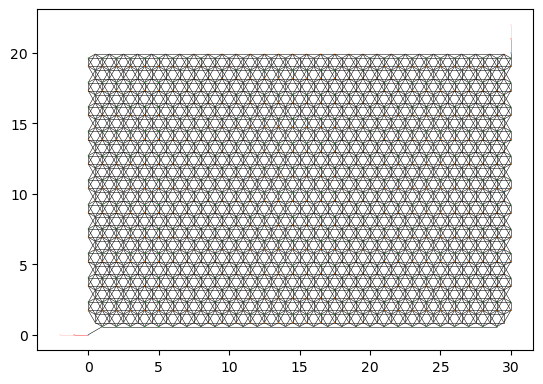

In [18]:
a = 1.0

args = SimpleNamespace(
    shape="rectangle",
    r=15,
    L=30,
    W=20,
    N_edge=20,
    t_prime=-0.2,
    t_2=0.0,
    m=0.0,
    disorder=0.0,
    phi=0.0,
    energy=0.0,
    Lx=10,
    R = 17,
    l = 17
)

# Define the shape of the system
shapes = ["triangular-zz", "ribbon", "triangular-ac", "hexagon-zz", "hexagon-ac", "circle", "rectangle"]
shape = args.shape
if shape not in shapes:
    raise ValueError(f"Shape {shape} not recognized. Choose from {shapes}")

# Define the dimensions of the system

diminsions = SimpleNamespace(r=args.r, R=args.r, l=args.l, Lx=args.Lx, L=args.L, W=args.W, N_edge=args.N_edge)
# diminsions.N_edge = 50 # will have perfect transmission that descends slowly, but ascends later that I aim for

# Create the system
sys = make_system(a, shape, diminsions)
sys_with_leads = deepcopy(sys)
sq_lattice = kwant.lattice.square(a=1.0, norbs=2)
add_second_lead = True

system_parameters = SimpleNamespace(phi=args.phi, t_2=args.t_2 + 1j * args.t_prime, m=args.m, disorder=args.disorder)

# attach leads

if shape == "triangular-zz":    
    # triangle -zz
    added_site =  sq_lattice(0, 1)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
    w1 = a_lat(0, 1)
    added_site2 = sq_lattice(diminsions.N_edge-2, 0)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([0, -1])) # w b(10, 0)
    w2 = b_lat(diminsions.N_edge-2, 0)
elif shape == "triangular-ac":
    # triangle -ac
    added_site = sq_lattice(0, 0)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 1)
    w1 = a_lat(0, 1)
    added_site2 = sq_lattice(8, 5)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(5, 5)
    w2 = b_lat(5, 5)
elif shape == "hexagon-zz":
    # hexagon -zz
    added_site = sq_lattice(-1, 0)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(0, 0)
    w1 = a_lat(0, 0)
    added_site2 = sq_lattice(30, 0)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(29, 0)
    w2 = b_lat(29, 0)
elif shape == "hexagon-ac":
# hexagon -ac
    added_site = sq_lattice(-diminsions.R, 0)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-12, 0)
    w1 = a_lat(-diminsions.R, -diminsions.R+1)
    added_site2 = sq_lattice(12, 0)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w b(12, 0)
    w2 = b_lat(12, 0)
elif shape == "circle":
# circle
    added_site = sq_lattice(-diminsions.r, 0)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0])) # w a(-6, 0)
    w1 = a_lat(-diminsions.r + 1, -1)
    added_site2 = sq_lattice(diminsions.r, 0)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0])) # w  a(6, 0)
    w2 = b_lat(diminsions.r - 1, 0)

elif shape == "rectangle":
    # rectangle
    added_site = sq_lattice(0, 0)
    _lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
    w1 = b_lat(1, 0)
    added_site2 = sq_lattice(diminsions.L, diminsions.W)
    _lead2 = kwant.Builder(kwant.TranslationalSymmetry([0, 1]))
    w2 = b_lat(diminsions.L-11, diminsions.W+2)
else:
    raise ValueError(f"Shape {shape} not recognized for lead attachment")

_lead1[added_site] = 0*sigma_0
_lead1[sq_lattice.neighbors(1)] = -2*sigma_0
sys_with_leads[added_site]  = 0*sigma_0
sys_with_leads[added_site,  w1] = -2*sigma_0
sys_with_leads.attach_lead(_lead1)

if add_second_lead:
    _lead2[added_site2] = 0*sigma_0
    _lead2[sq_lattice.neighbors(1)] = 2*sigma_0
    sys_with_leads[added_site2] = 0*sigma_0
    sys_with_leads[added_site2, w2] = 2*sigma_0
    sys_with_leads.attach_lead(_lead2)


sys_with_leads_fin = sys_with_leads.finalized()

kwant.plot(sys_with_leads_fin, site_size=0.1, show=False, lead_site_edgecolor="black", site_edgecolor="blue")
plt.show()


In [19]:
wf = kwant.wave_function(sys_with_leads_fin, args.energy, params=dict(param=system_parameters))
try:
    psi = np.sum(wf(0), axis=0)
    psi_inv = np.sum(wf(1), axis=0) if add_second_lead else None
except IndexError:
    print("No wave function at the added site, check the energy.")

rho = kwant.operator.Density(sys_with_leads_fin, sigma_0)
rho_sz = kwant.operator.Density(sys_with_leads_fin, sigma_z)
density = rho(psi, params=dict(param=system_parameters))
spin_z = rho_sz(psi, params=dict(param=system_parameters))
density_inv = rho(psi_inv, params=dict(param=system_parameters)) if add_second_lead else None
spin_z_inv = rho_sz(psi_inv, params=dict(param=system_parameters)) if add_second_lead else None

J0 = kwant.operator.Current(sys_with_leads_fin)
Jz = kwant.operator.Current(sys_with_leads_fin, sigma_z)
current = J0(psi, params=dict(param=system_parameters))
spin_z_current = Jz(psi, params=dict(param=system_parameters))
current_inv = J0(psi_inv, params=dict(param=system_parameters)) if add_second_lead else None
spin_z_current_inv = Jz(psi_inv, params=dict(param=system_parameters)) if add_second_lead else None



def top_half(site):
    x, y = site.pos
    return y > 0
def bottom_half(site):
    x, y = site.pos
    return y < 0

rho_top = kwant.operator.Density(sys_with_leads_fin, sigma_0, where=top_half, sum=True)
rho_bottom = kwant.operator.Density(sys_with_leads_fin, sigma_0, where=bottom_half, sum=True)
rho_z_top = kwant.operator.Density(sys_with_leads_fin, sigma_z, where=top_half, sum=True)
rho_z_bottom = kwant.operator.Density(sys_with_leads_fin, sigma_z, where=bottom_half, sum=True)


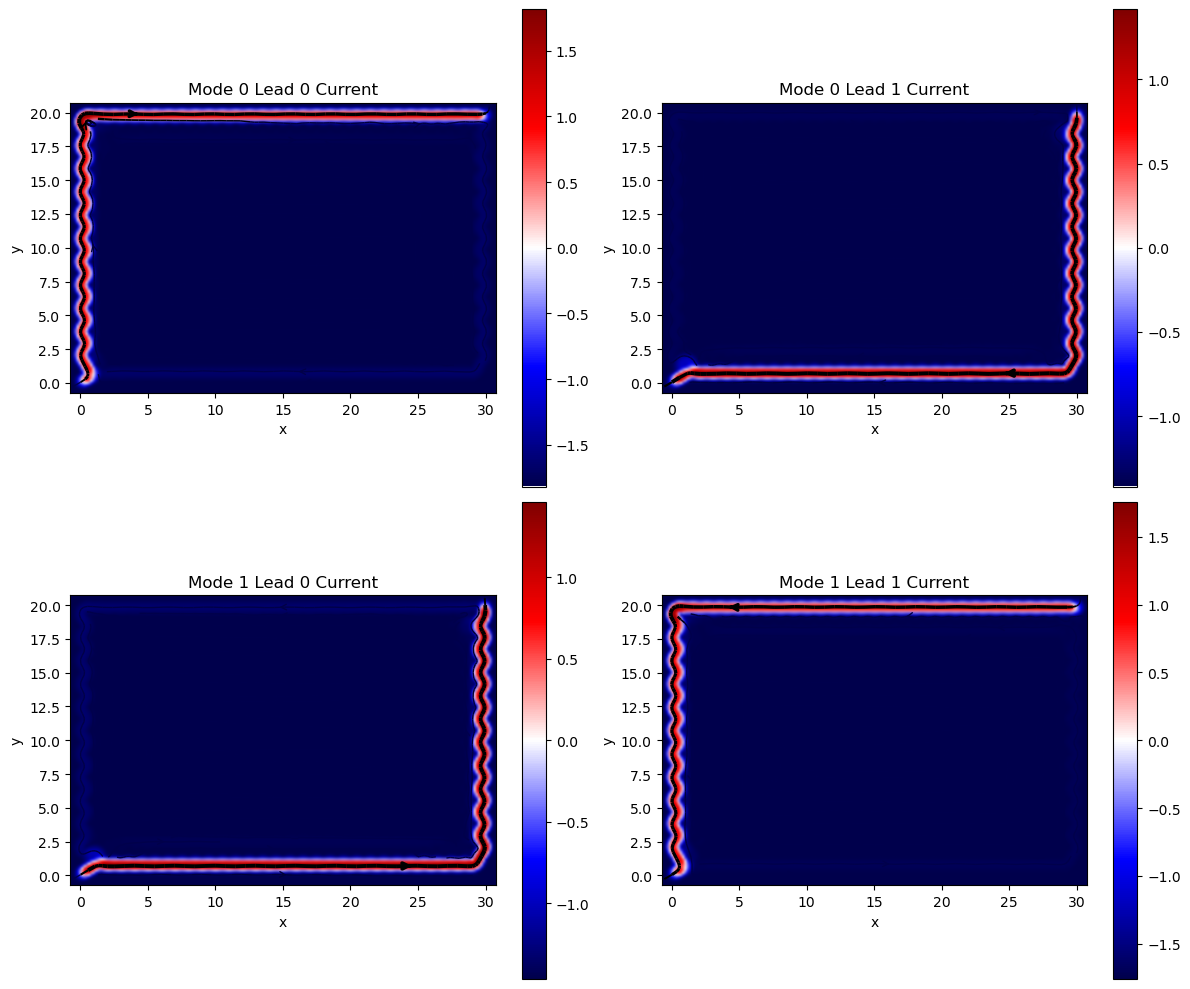

In [20]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# kwant.plotter.map(sys_with_leads_fin, density)
# kwant.plotter.map(sys_with_leads_fin, spin_z)
# kwant.plotter.current(sys_with_leads_fin, current)
# kwant.plotter.current(sys_with_leads_fin, spin_z_current)
# plt.show()
# quit()
plot_the_densities = False
if plot_the_densities:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    # 1. Local electron density
    vmin, vmax = 0, 1
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.Reds
    kwant.plotter.map(sys_with_leads_fin, density, ax=axs[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[0, 0])
    axs[0, 0].set_title("Local electron density")
    axs[0, 0].set_xlabel("x")
    axs[0, 0].set_ylabel("y")

    # 2. Spin-polarized density (S_z)
    vmin, vmax = spin_z.min(), spin_z.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.coolwarm
    kwant.plotter.map(sys_with_leads_fin, spin_z, ax=axs[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[0, 1])
    axs[0, 1].set_title("Spin-polarized density ($S_z$)")
    axs[0, 1].set_xlabel("x")
    axs[0, 1].set_ylabel("y")

    # 3. Local current
    vmin, vmax = current.min(), current.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, current, ax=axs[1, 0], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[1, 0])
    axs[1, 0].set_title("Local current")
    axs[1, 0].set_xlabel("x")
    axs[1, 0].set_ylabel("y")

    # 4. Spin-polarized current (S_z)
    vmin, vmax = spin_z_current.min(), spin_z_current.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, spin_z_current, ax=axs[1, 1], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[1, 1])
    axs[1, 1].set_title("Spin-polarized current ($S_z$)")
    axs[1, 1].set_xlabel("x")
    axs[1, 1].set_ylabel("y")
    plt.tight_layout()
    plt.show()

plot_modes = True
if plot_modes and add_second_lead:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    zcurrent_00 = J0(wf(0)[0], params=dict(param=system_parameters))
    vmin, vmax = zcurrent_00.min(), zcurrent_00.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, zcurrent_00, ax=axs[0, 0], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[0, 0])
    axs[0, 0].set_title("Mode 0 Lead 0 Current")
    axs[0, 0].set_xlabel("x")
    axs[0, 0].set_ylabel("y")
    
    zcurrent_01 = J0(wf(1)[0], params=dict(param=system_parameters))
    vmin, vmax = zcurrent_01.min(), zcurrent_01.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, zcurrent_01, ax=axs[0, 1], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[0, 1])
    axs[0, 1].set_title("Mode 0 Lead 1 Current")
    axs[0, 1].set_xlabel("x")
    axs[0, 1].set_ylabel("y")

    zcurrent_10 = J0(wf(0)[1], params=dict(param=system_parameters))
    vmin, vmax = zcurrent_10.min(), zcurrent_10.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, zcurrent_10, ax=axs[1, 0], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[1, 0])
    axs[1, 0].set_title("Mode 1 Lead 0 Current")
    axs[1, 0].set_xlabel("x")
    axs[1, 0].set_ylabel("y")

    zcurrent_11 = J0(wf(1)[1], params=dict(param=system_parameters))
    vmin, vmax = zcurrent_11.min(), zcurrent_11.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic
    kwant.plotter.current(sys_with_leads_fin, zcurrent_11, ax=axs[1, 1], cmap=cmap, show=False)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[1, 1])
    axs[1, 1].set_title("Mode 1 Lead 1 Current")
    axs[1, 1].set_xlabel("x")
    axs[1, 1].set_ylabel("y")
    
    plt.tight_layout()
    plt.show()


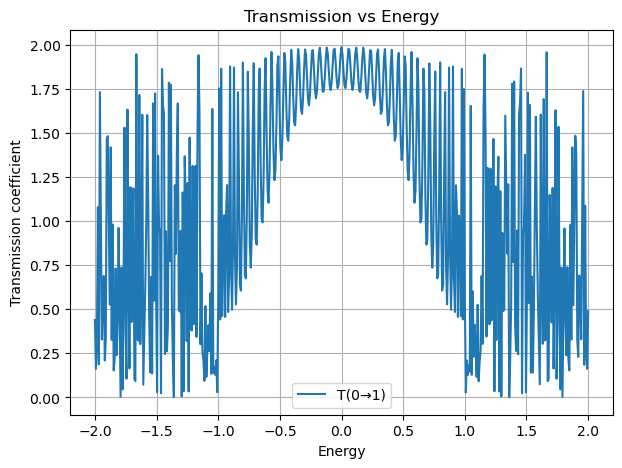

In [21]:
energies = np.linspace(-2.00001, 2.000001, 501)
transmissions = []

for energy in energies:
    smatrix = kwant.smatrix(sys_with_leads_fin, energy, params=dict(param=system_parameters))
    transmissions.append(smatrix.transmission(0, 1))

plt.figure(figsize=(7, 5))
plt.plot(energies, transmissions, label="T(0→1)")
plt.xlabel("Energy")
plt.ylabel("Transmission coefficient")
plt.title("Transmission vs Energy")
plt.legend()
plt.grid(True)
plt.show()

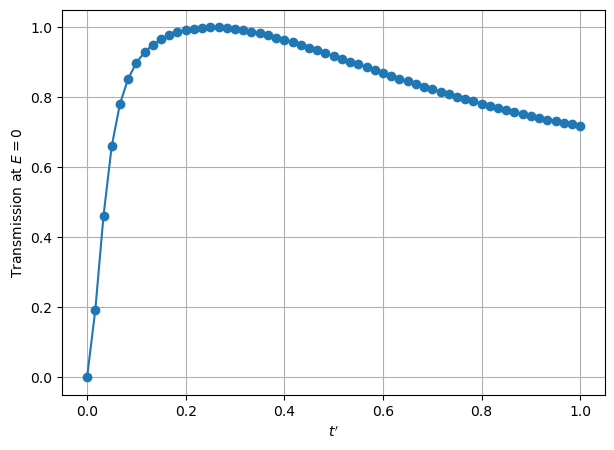

In [7]:
import copy
t_prime_values = np.linspace(0.0, 1.0, 61)
transmissions_tprime = []

for t_prime in t_prime_values:
    params = copy.deepcopy(system_parameters)
    params.t_2 = 1j * t_prime 
    smatrix = kwant.smatrix(sys_with_leads_fin, 0.0, params=dict(param=params))
    transmissions_tprime.append(smatrix.transmission(0, 1)/2)

plt.figure(figsize=(7, 5))
plt.plot(t_prime_values, transmissions_tprime, marker='o')
plt.xlabel("$t'$")
plt.ylabel("Transmission at $E=0$")
# plt.title("Transmission vs $t'$ at $E=0$")
plt.grid(True)
plt.show()

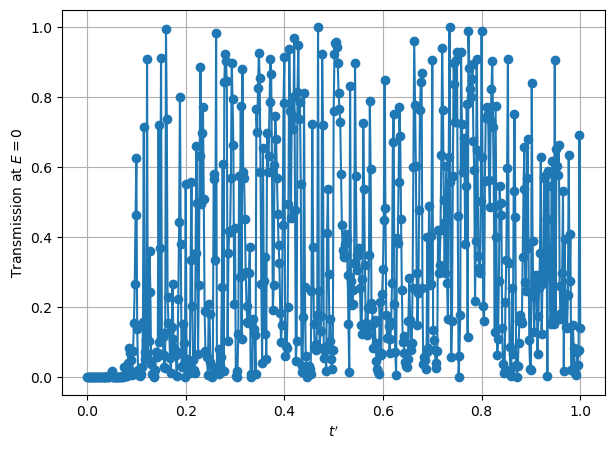

In [ ]:
import copy
phi_values = np.linspace(0.0, 1.0, 61)
transmissions_normal = []
for phi in phi_values:
    params = copy.deepcopy(system_parameters)
    params.t_2 = 0.0
    params.phi = phi
    smatrix = kwant.smatrix(sys_with_leads_fin, -1.00001, params=dict(param=params))
    transmissions_normal.append(smatrix.transmission(0, 1)/2)

plt.figure(figsize=(7, 5))
plt.plot(phi_values, transmissions_normal, marker='o')
plt.xlabel("$t'$")
plt.ylabel("Transmission at $E=0$")
# plt.title("Transmission vs $t'$ at $E=0$")
plt.grid(True)
plt.show()